### IF you guys have any suggestions at all, or better way to do this, or do not want to do this way, please speak up, we can do it that way too.
#### Hey Guys! If everyone is okay, this will be our main document.
#### Remember to pull before you start working.
#### I will recommend that each of us have two copies of this ipynb.
#### One will be your personal, whatever work you do will be there. It will serve as scratchpad of sorts.
#### Once you are done, you can do git pull, copy paste your work in the main document, beautify it and then push. This way we wont have any trouble with version controlling.


Project checkpoint 1 (15%): For this milestone, you will need to have downloaded the data, and
also run some initial pre-processing on it. You should also make at least one dummy submission
(all-positive, all-negative, most-frequency) on Kaggle and submit the Jupyter Notebook including
the code and a screenshot of the score on Canvas.

The dataset had three different data sets.
The "train.csv" file contains the sequence and corresponding sensor data. Each sequence has 60 data points or sensor readings. There are total 12 different sensors. Moreover, each sequence number is associated with a unique subject. The variable "step" is simply a counter that runs from 0 to 59 for each sequence or each subject. Important thing about this datafile is that there are no labels included. The image below shows a snippet of the .csv file.

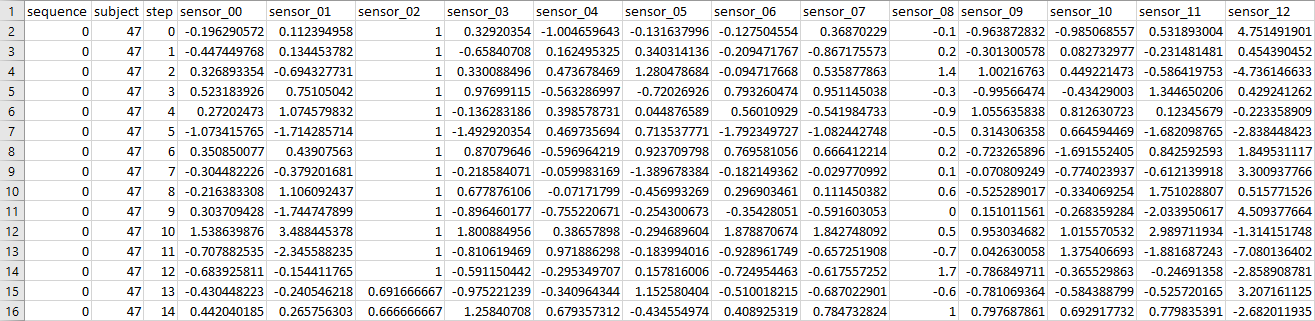

The "train_lables.csv" file contains the labels for the all the datapoints in "train.csv". It has only two columns: sequence and state.

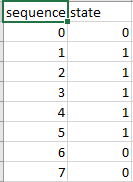

In [ ]:

X_train = pd.read_csv("train.csv")
y_train = pd.read_csv("train_labels.csv")